In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


import os
import numpy as np
import pandas as np
import seaborn as sns

from random import randint
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
main_dir = r"C:\Users\anike\Pneumonia detection model\chest_xray"
train_data_dir = r"C:\Users\anike\Pneumonia detection model\chest_xray\train"
validation_data_dir = r"C:\Users\anike\Pneumonia detection model\chest_xray\val"
test_data_dir = r"C:\Users\anike\Pneumonia detection model\chest_xray\test"

nb_train_samples = 5216
nb_validation_samples = 16
epochs = 30
batch_size = 64

print("Working Directory Contents:", os.listdir(main_dir))

Working Directory Contents: ['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [8]:
train_n = r"C:\Users\anike\Pneumonia detection model\chest_xray\train\NORMAL"
train_p = r"C:\Users\anike\Pneumonia detection model\chest_xray\test\PNEUMONIA"

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 1731
length of pneumonia cases in training set: 390
length of normal cases in training set: 1341


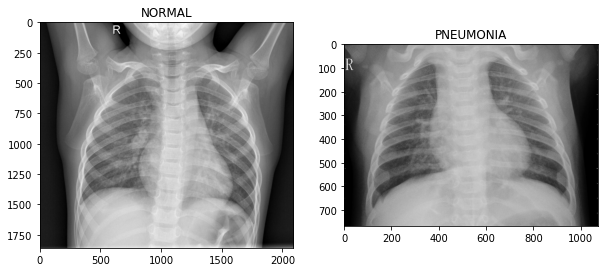

In [12]:
img_name = '\IM-0115-0001.jpeg'
img_normal = load_img(r'C:\Users\anike\Pneumonia detection model\chest_xray\train\NORMAL' + img_name)

img_name_1 = '\person1000_virus_1681.jpeg'
img_pneumonia = load_img(r'C:\Users\anike\Pneumonia detection model\chest_xray\train\PNEUMONIA' + img_name_1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

In [16]:
img_height, img_width  = 180, 180


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


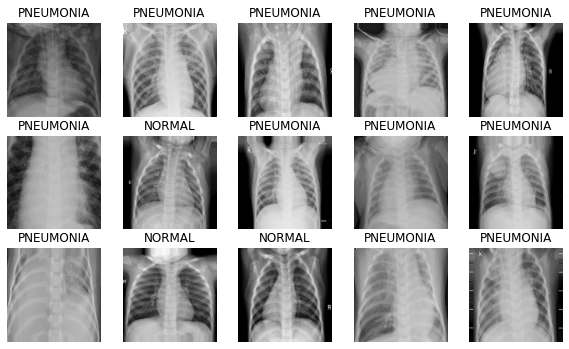

In [20]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0

In [24]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('Pneumonia_Model.h5',monitor='loss', save_best_only=True) # saving the best model
]

In [25]:
count_normal = len(train_n)
count_pneumonia = len(train_p)

initial_bias = count_pneumonia / count_normal
print("Initial bias: {:.5f}".format(initial_bias))

TRAIN_IMG_COUNT = count_normal + count_pneumonia
weight_for_0 = (1 / count_normal) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / count_pneumonia) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.03125
Weight for class 0: 1.02
Weight for class 1: 0.98


In [26]:
METRICS = [tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=METRICS)

In [27]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks1)

Epoch 1/30
82/82 [==============================] - 98s 1s/step - loss: 0.6348 - binary_accuracy: 0.7481 - precision: 0.7633 - recall: 0.9579 - val_loss: 0.9422 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 95s 1s/step - loss: 0.3632 - binary_accuracy: 0.8263 - precision: 0.8423 - recall: 0.9427 - val_loss: 1.8157 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 97s 1s/step - loss: 0.3126 - binary_accuracy: 0.8710 - precision: 0.8936 - recall: 0.9381 - val_loss: 0.5542 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 96s 1s/step - loss: 0.2639 - binary_accuracy: 0.8967 - precision: 0.9216 - recall: 0.9409 - val_loss: 0.4016 - val_binary_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 101s

In [28]:
scores = model.evaluate(test_generator, return_dict=True)

print(scores)

10/10 [==============================] - 4s 427ms/step - loss: 0.5249 - binary_accuracy: 0.8830 - precision: 0.8578 - recall: 0.9744
{'loss': 0.5248667001724243, 'binary_accuracy': 0.8830128312110901, 'precision': 0.8577877879142761, 'recall': 0.9743589758872986}


In [30]:
from keras.models import load_model

model.save('Pneumonia_Model.h5')

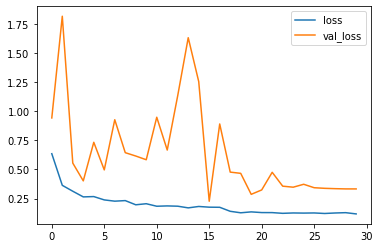

In [31]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [36]:
def predict_image(filename):
    img = load_img(filename, target_size=(img_height, img_width))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,180,180,3)
    model = load_model('Pneumonia_Model.h5')
    prediction = model.predict(image)
    plt.imshow(img)
    if(prediction[0] > 0.5):
        stat = prediction[0] * 100 
        print("This image is %.2f percent %s"% (stat, "PNEUMONIA"))
    else:
        stat = (1.0 - prediction[0]) * 100
        print("This image is %.2f percent %s" % (stat, "NORMAL"))

This image is 85.24 percent NORMAL


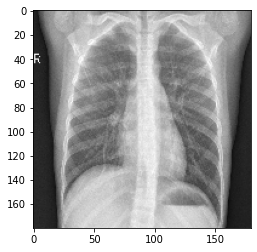

In [38]:
predict_image(r"C:\Users\anike\Pneumonia detection model\chest_xray\test\NORMAL\IM-0003-0001.jpeg")